In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set(style="whitegrid", rc={'figure.figsize':(12,8)})
%matplotlib inline

In [2]:
# Load your car data
data = pd.read_csv("Data/data.csv")  # Replace with your actual data path
print(f"Data shape: {data.shape}")
data.head()

Data shape: (11914, 16)


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [3]:
# Basic info
print("Data Info:")
print(data.info())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Numerical stats
print("\nNumerical Features Stats:")
print(data.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(

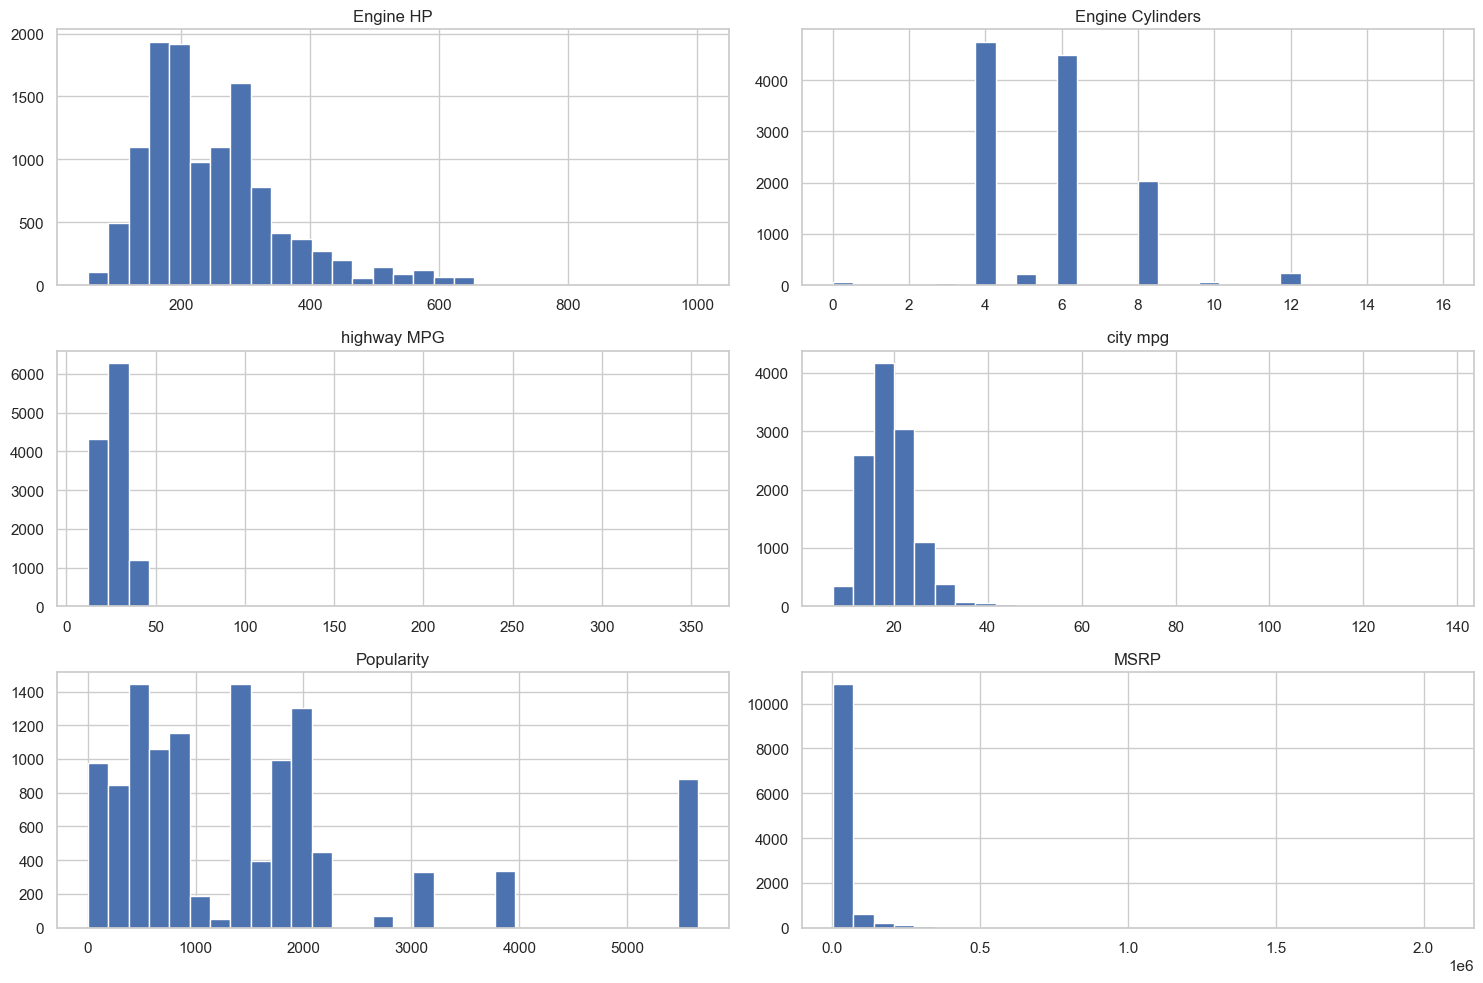

In [4]:
# Plot distributions of numerical features
num_cols = ['Engine HP', 'Engine Cylinders', 'highway MPG', 'city mpg', 'Popularity', 'MSRP']
data[num_cols].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

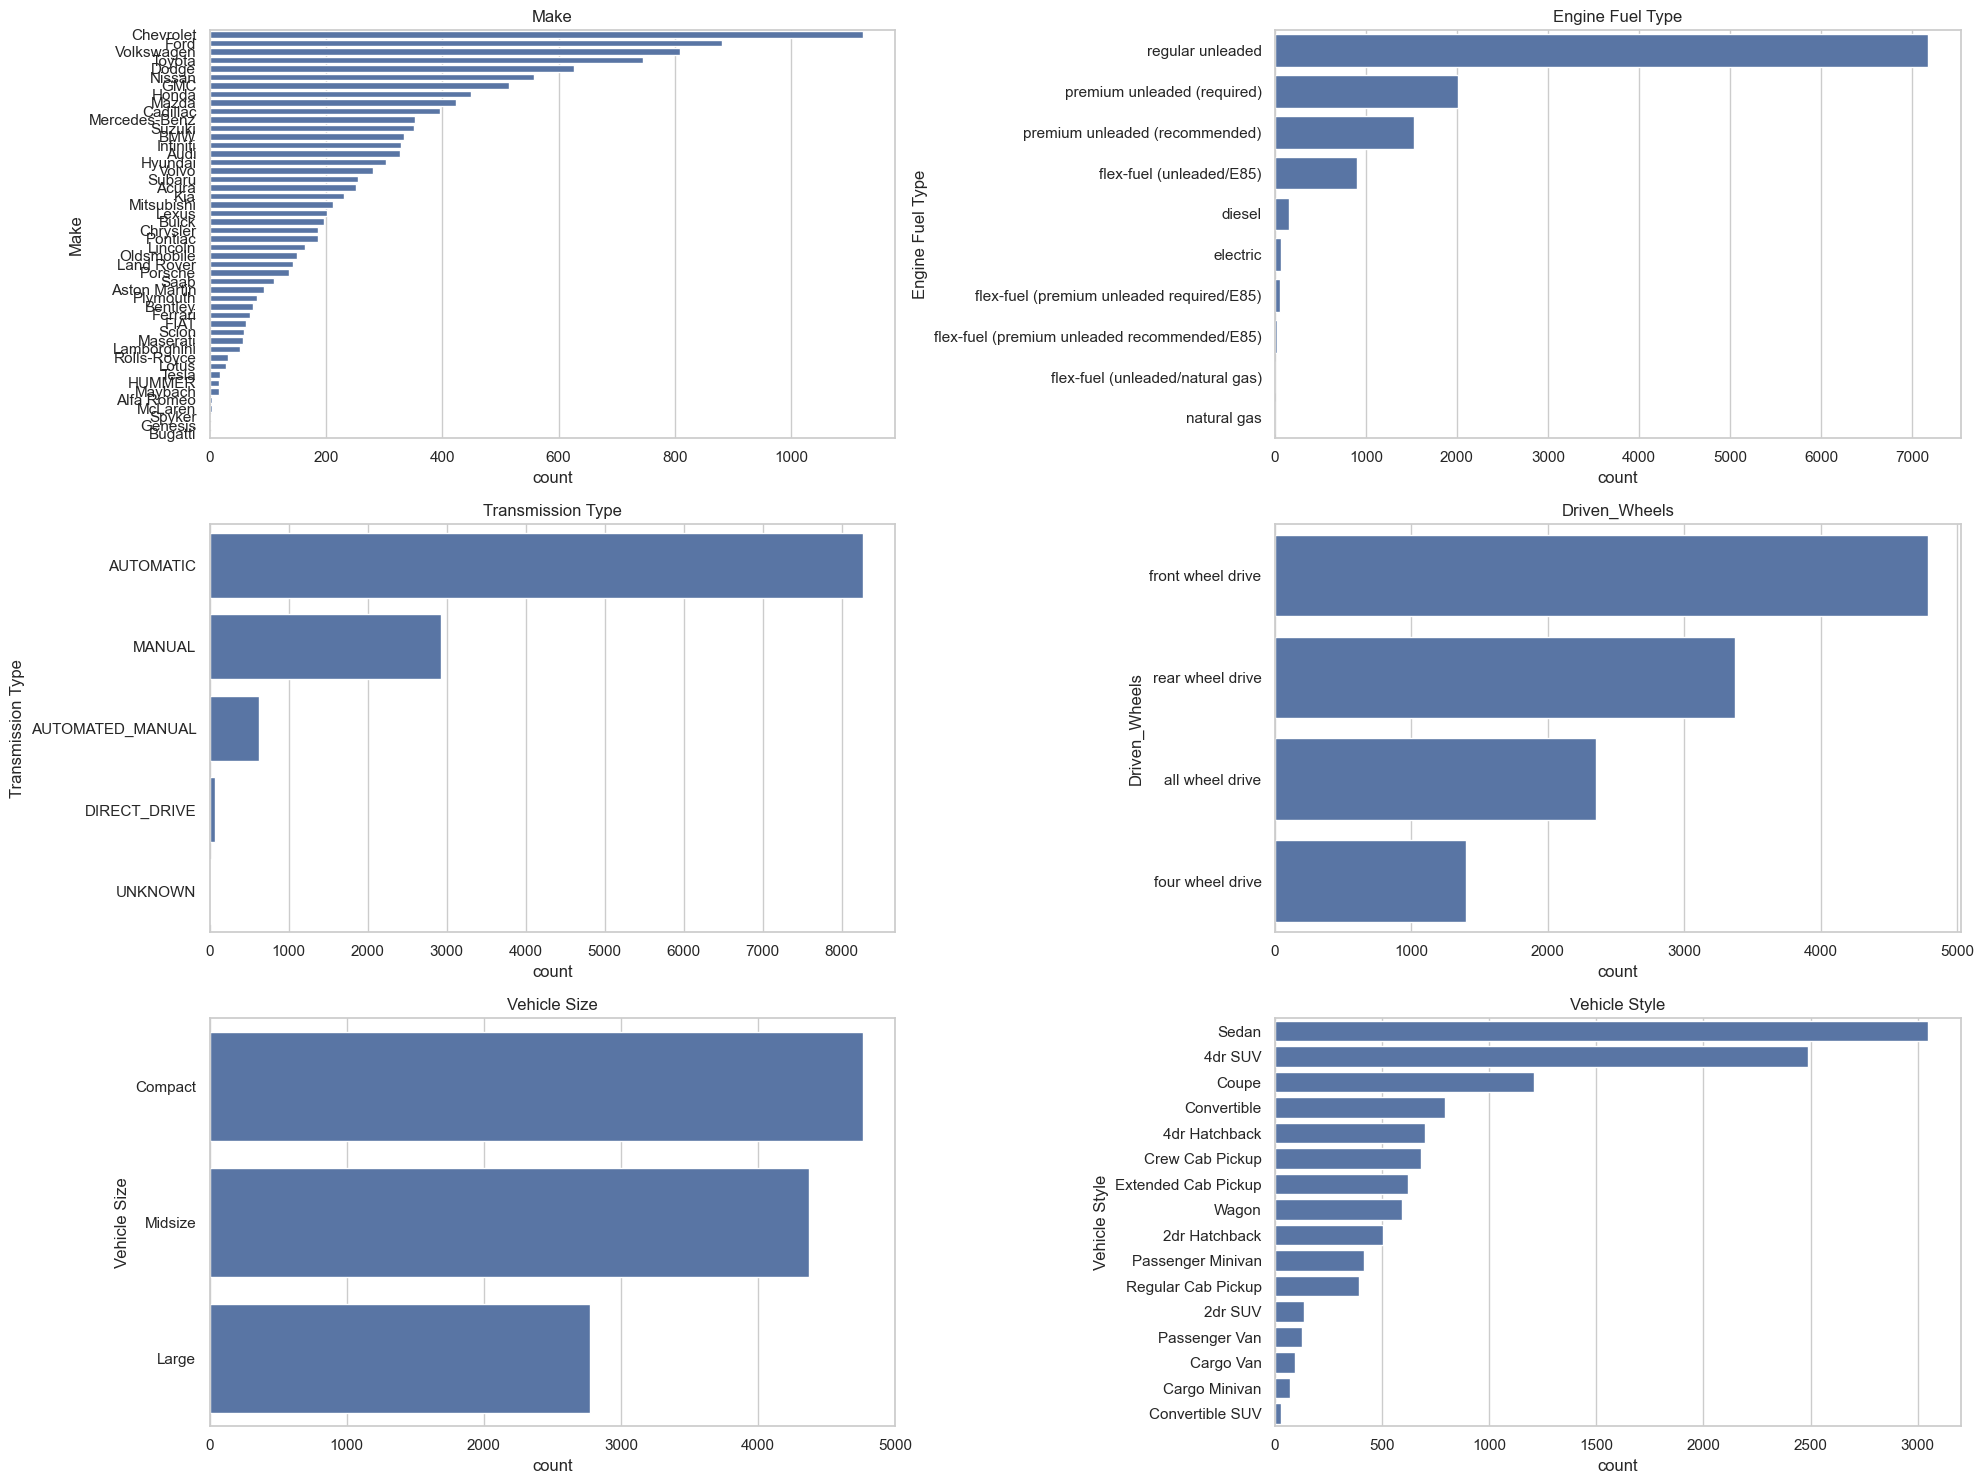

In [5]:
# Plot counts of categorical features
cat_cols = ['Make', 'Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Vehicle Size', 'Vehicle Style']

plt.figure(figsize=(20, 15))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 2, i)
    sns.countplot(y=data[col], order=data[col].value_counts().index)
    plt.title(col)
plt.tight_layout()
plt.show()

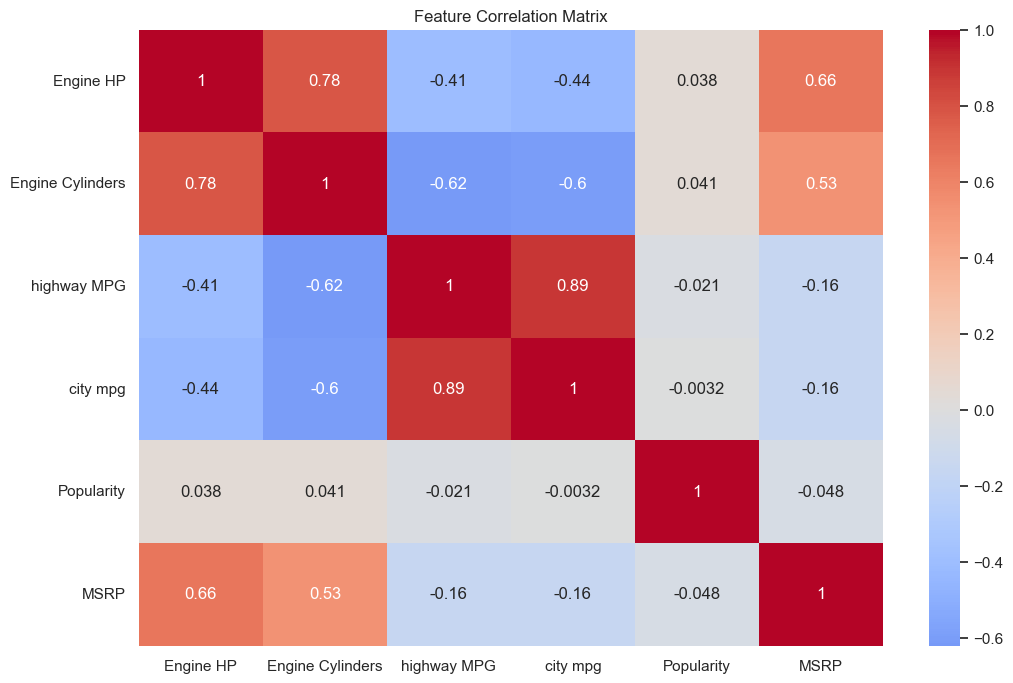

In [6]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = data[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

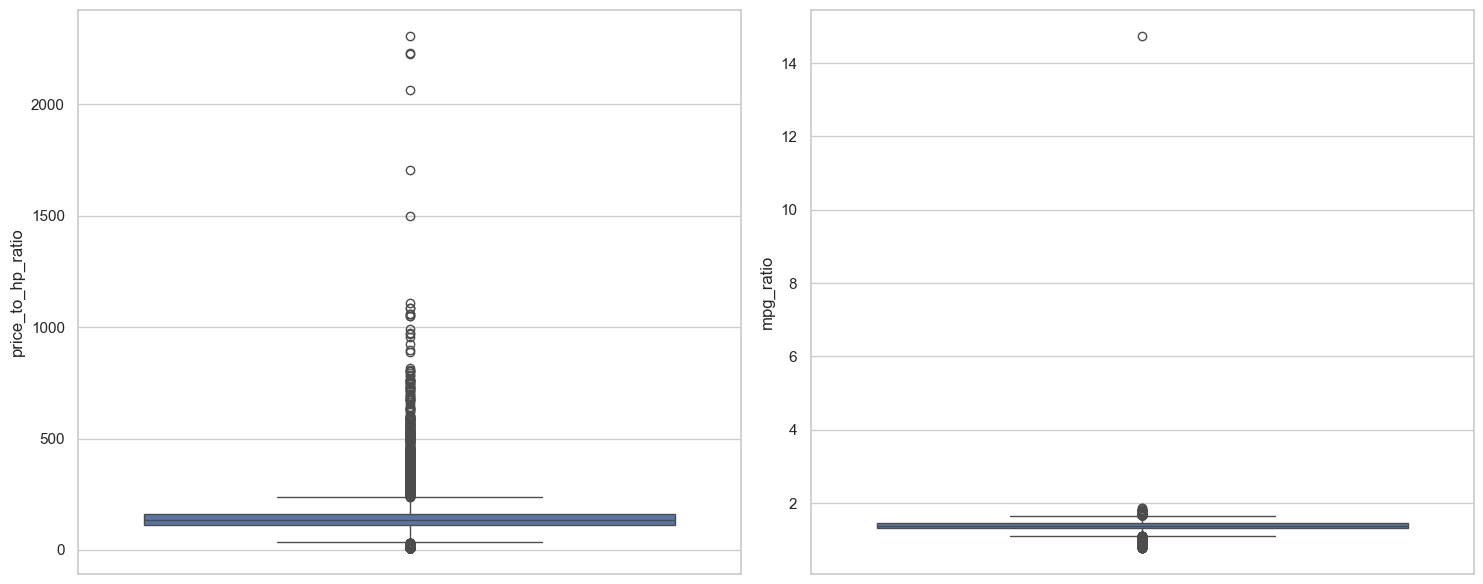

In [7]:
# Create a new feature that might help detect anomalies
data['price_to_hp_ratio'] = data['MSRP'] / data['Engine HP']
data['mpg_ratio'] = data['highway MPG'] / data['city mpg']

# Plot the new features
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(data['price_to_hp_ratio'], ax=ax[0])
sns.boxplot(data['mpg_ratio'], ax=ax[1])
plt.tight_layout()
plt.show()

In [8]:
"""
Anomaly Detection Strategy:
1. We'll use Isolation Forest which works well for multivariate anomaly detection
2. Focus on these key features:
   - Engine specifications (HP, Cylinders)
   - Fuel efficiency (MPG)
   - Price metrics (MSRP, price_to_hp_ratio)
   - Popularity
3. We'll preprocess data (scale numerical, encode categorical)
4. Visualize anomalies in 2D using PCA
5. Analyze detected anomalies for business insights
"""

"\nAnomaly Detection Strategy:\n1. We'll use Isolation Forest which works well for multivariate anomaly detection\n2. Focus on these key features:\n   - Engine specifications (HP, Cylinders)\n   - Fuel efficiency (MPG)\n   - Price metrics (MSRP, price_to_hp_ratio)\n   - Popularity\n3. We'll preprocess data (scale numerical, encode categorical)\n4. Visualize anomalies in 2D using PCA\n5. Analyze detected anomalies for business insights\n"

In [9]:
# Define features to use for anomaly detection
features = [
    'Engine HP', 'Engine Cylinders', 'highway MPG', 'city mpg', 
    'Popularity', 'MSRP', 'price_to_hp_ratio', 'mpg_ratio'
]

# Create feature set
X = data[features].copy()

# Handle missing values if any
X = X.fillna(X.median())

print("Feature set shape:", X.shape)

Feature set shape: (11914, 8)


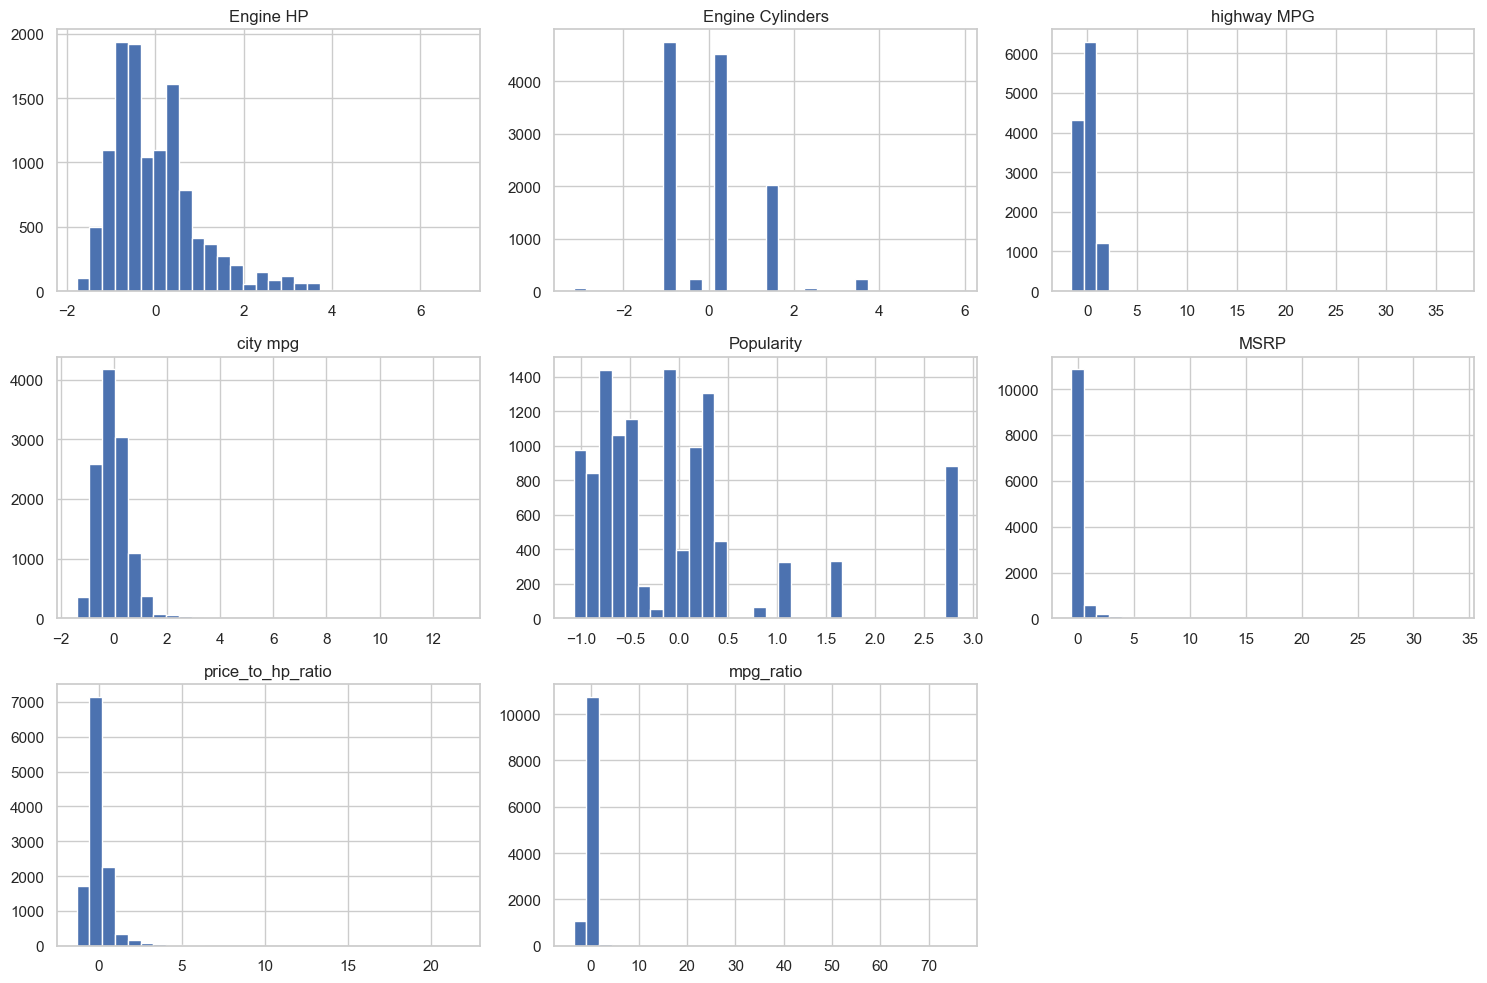

In [10]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for visualization
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Plot scaled distributions
X_scaled_df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [11]:
# Initialize Isolation Forest
iso_forest = IsolationForest(
    n_estimators=150, 
    max_samples='auto', 
    contamination=0.05,  # Expected proportion of outliers
    random_state=42,
    verbose=1
)

In [12]:
# Fit the model
iso_forest.fit(X_scaled)

# Get anomaly scores (-1 for outliers, 1 for inliers)
predictions = iso_forest.predict(X_scaled)
scores = iso_forest.decision_function(X_scaled)

# Add results to original data
data['anomaly_score'] = scores
data['anomaly'] = predictions
data['anomaly'] = data['anomaly'].map({1: 0, -1: 1})  # 1 for anomaly, 0 for normal

print("Anomaly counts:")
print(data['anomaly'].value_counts())

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Anomaly counts:
anomaly
0    11318
1      596
Name: count, dtype: int64


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


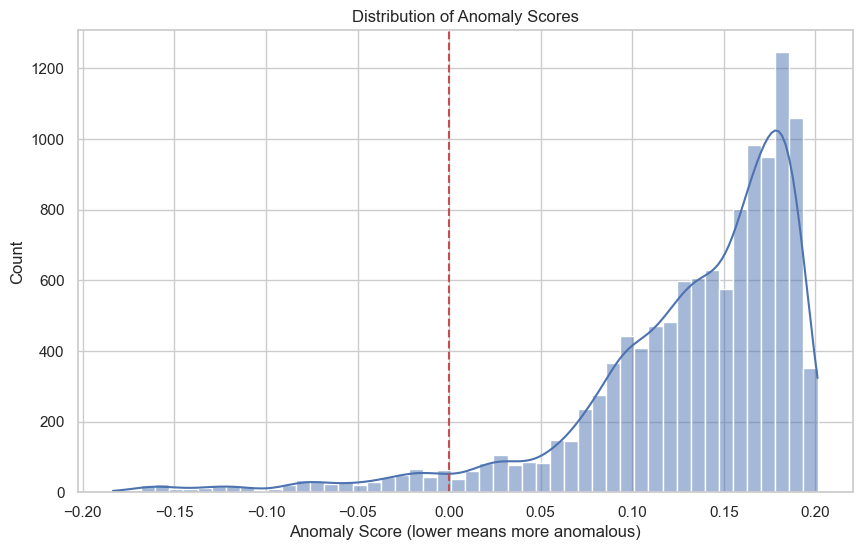

In [13]:
# Plot distribution of anomaly scores
plt.figure(figsize=(10, 6))
sns.histplot(data['anomaly_score'], bins=50, kde=True)
plt.axvline(x=np.percentile(data['anomaly_score'], 5), color='r', linestyle='--')
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score (lower means more anomalous)")
plt.show()

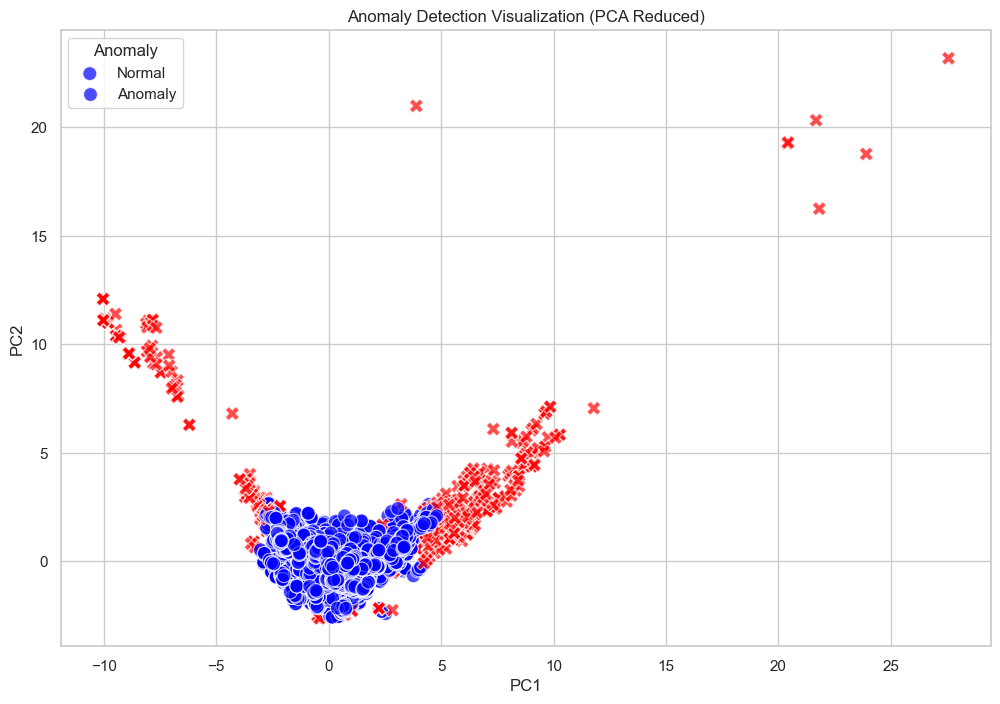

In [14]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plot_df['anomaly'] = data['anomaly']
plot_df['Make'] = data['Make']
plot_df['MSRP'] = data['MSRP']

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='anomaly', 
    style='anomaly',
    palette={0: 'blue', 1: 'red'},
    data=plot_df,
    s=100,
    alpha=0.7
)
plt.title("Anomaly Detection Visualization (PCA Reduced)")
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
plt.show()

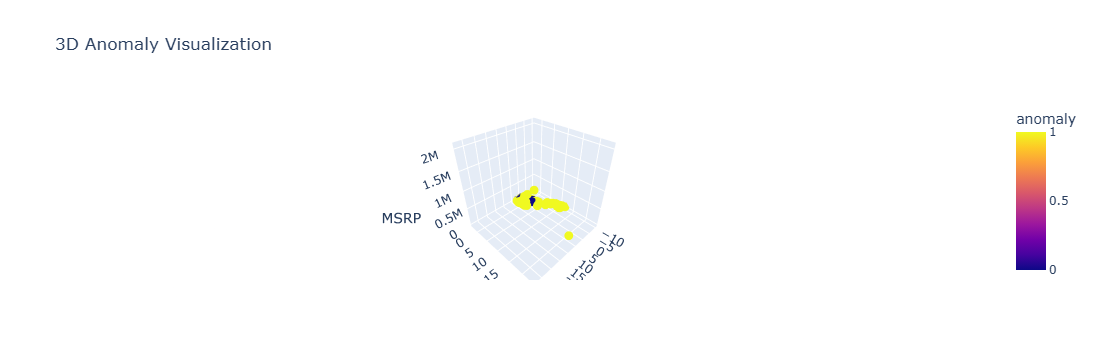

In [15]:
# Interactive 3D plot with Plotly
fig = px.scatter_3d(
    plot_df, 
    x='PC1', 
    y='PC2', 
    z='MSRP',
    color='anomaly',
    color_discrete_map={0: 'blue', 1: 'red'},
    hover_data=['Make'],
    title="3D Anomaly Visualization"
)
fig.update_traces(marker=dict(size=5))
fig.show()

In [16]:
# Get top 20 most anomalous examples
top_anomalies = data[data['anomaly'] == 1].sort_values('anomaly_score').head(20)

print("Top 20 Anomalies:")
display(top_anomalies[['Make', 'Model', 'Year', 'MSRP', 'Engine HP', 'anomaly_score']])

Top 20 Anomalies:


,Make,Model,Year,MSRP,Engine HP,anomaly_score
11362,Bugatti,Veyron 16.4,2008,2065902,1001.0,-0.183527
11364,Bugatti,Veyron 16.4,2009,1705769,1001.0,-0.182179
5793,BMW,i3,2017,43600,170.0,-0.180885
11363,Bugatti,Veyron 16.4,2008,1500000,1001.0,-0.180833
5791,BMW,i3,2016,42400,170.0,-0.180549
5792,BMW,i3,2017,42400,170.0,-0.180549
5790,BMW,i3,2015,42400,170.0,-0.180549
4785,Ford,Focus,2015,29170,NaN,-0.169106
4789,Ford,Focus,2016,29170,NaN,-0.169106
4798,Ford,Focus,2017,29120,NaN,-0.169106


In [17]:
# Analyze which features contribute most to anomalies
anomaly_features = data[data['anomaly'] == 1][features]
normal_features = data[data['anomaly'] == 0][features]

# Compare means
feature_comparison = pd.DataFrame({
    'Normal_Mean': normal_features.mean(),
    'Anomaly_Mean': anomaly_features.mean(),
    'Difference': anomaly_features.mean() - normal_features.mean()
})

feature_comparison.sort_values('Difference', ascending=False)

,Normal_Mean,Anomaly_Mean,Difference
MSRP,33147.344142,182020.228188,148872.884046
Popularity,1541.284149,1813.687919,272.403770
price_to_hp_ratio,128.170996,387.842826,259.671829
Engine HP,241.421943,412.318841,170.896898
city mpg,19.180156,30.236577,11.056422
highway MPG,26.280703,33.412752,7.132048
Engine Cylinders,5.508232,7.953925,2.445693
mpg_ratio,1.379194,1.374082,-0.005112


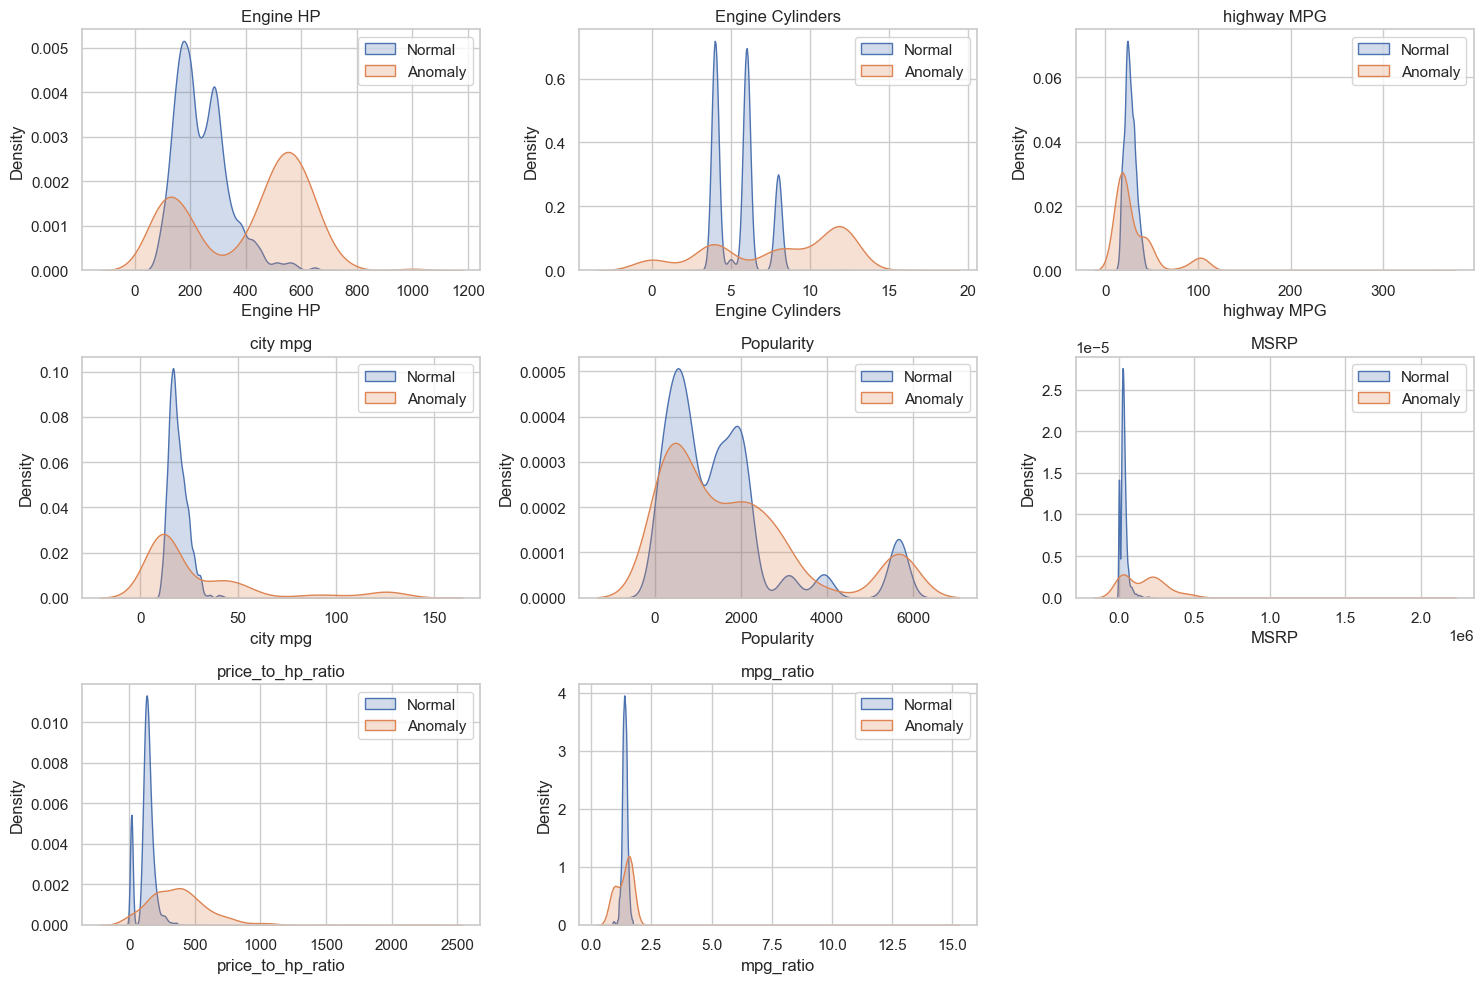

In [18]:
# Plot feature distributions for normal vs anomalies
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.kdeplot(normal_features[col], label='Normal', fill=True)
    sns.kdeplot(anomaly_features[col], label='Anomaly', fill=True)
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Categorize anomalies based on extreme values
def categorize_anomaly(row):
    if row['MSRP'] > data['MSRP'].quantile(0.95) and row['Engine HP'] < data['Engine HP'].quantile(0.05):
        return "Overpriced Low-Power"
    elif row['MSRP'] < data['MSRP'].quantile(0.05) and row['Engine HP'] > data['Engine HP'].quantile(0.95):
        return "Underpriced High-Power"
    elif row['price_to_hp_ratio'] > data['price_to_hp_ratio'].quantile(0.95):
        return "High Price/HP Ratio"
    elif row['mpg_ratio'] < data['mpg_ratio'].quantile(0.05):
        return "Unusual MPG Ratio"
    else:
        return "Other Anomaly"

data['anomaly_type'] = data[data['anomaly'] == 1].apply(categorize_anomaly, axis=1)
data['anomaly_type'] = data['anomaly_type'].fillna('Normal')

print("Anomaly Types Distribution:")
print(data['anomaly_type'].value_counts())

Anomaly Types Distribution:
anomaly_type
Normal                 11318
High Price/HP Ratio      351
Unusual MPG Ratio        173
Other Anomaly             72
Name: count, dtype: int64


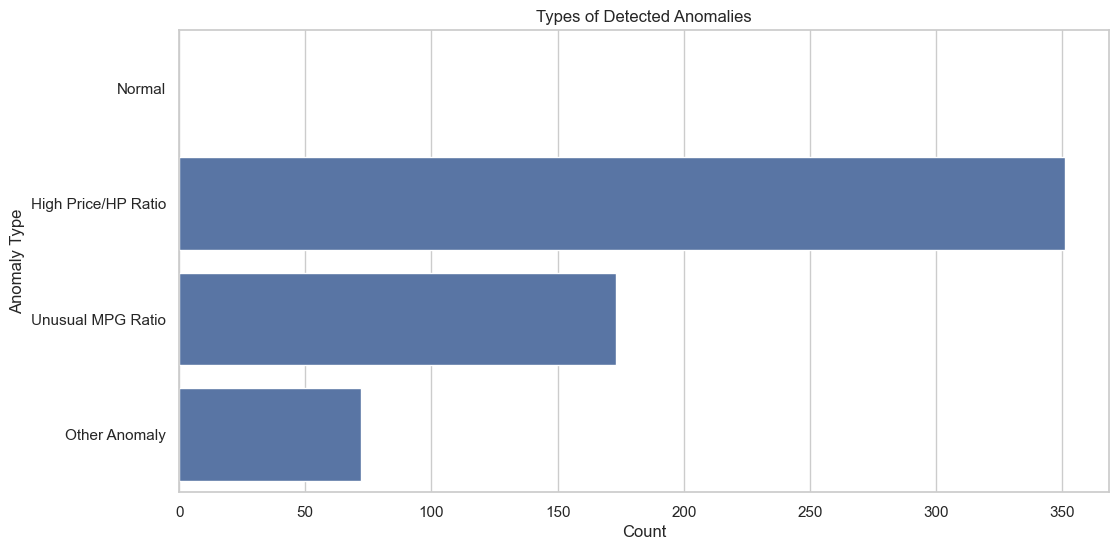

In [20]:
# Plot anomaly types
plt.figure(figsize=(12, 6))
sns.countplot(
    y='anomaly_type', 
    data=data[data['anomaly_type'] != 'Normal'],
    order=data['anomaly_type'].value_counts().index
)
plt.title("Types of Detected Anomalies")
plt.xlabel("Count")
plt.ylabel("Anomaly Type")
plt.show()

In [21]:
# Analyze which makes have most anomalies
make_anomalies = data.groupby('Make')['anomaly'].agg(['sum', 'count'])
make_anomalies['anomaly_rate'] = make_anomalies['sum'] / make_anomalies['count']
make_anomalies = make_anomalies.sort_values('anomaly_rate', ascending=False)

print("Anomaly Rates by Make:")
display(make_anomalies.head(10))

Anomaly Rates by Make:


,sum,count,anomaly_rate
Make,,,
Bugatti,3,3,1.000000
Tesla,18,18,1.000000
Rolls-Royce,31,31,1.000000
Maybach,16,16,1.000000
Lamborghini,50,52,0.961538
Bentley,67,74,0.905405
Ferrari,62,69,0.898551
Aston Martin,61,93,0.655914
McLaren,3,5,0.600000


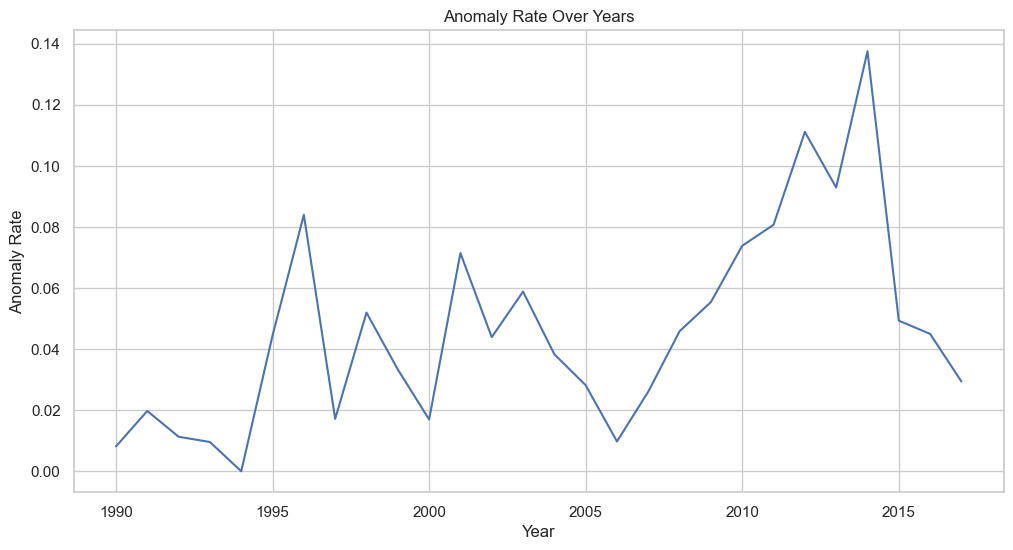

In [22]:
# Analyze anomalies by year
yearly_anomalies = data.groupby('Year')['anomaly'].agg(['sum', 'count'])
yearly_anomalies['anomaly_rate'] = yearly_anomalies['sum'] / yearly_anomalies['count']

plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_anomalies.index, y='anomaly_rate', data=yearly_anomalies)
plt.title("Anomaly Rate Over Years")
plt.ylabel("Anomaly Rate")
plt.xlabel("Year")
plt.show()

In [23]:
# Save the data with anomaly labels
data.to_csv('car_data_with_anomalies.csv', index=False)
print("Saved data with anomaly labels.")

Saved data with anomaly labels.


In [24]:
# Create synthetic anomalies for validation
np.random.seed(42)
synthetic = data.copy()
anomaly_indices = np.random.choice(len(synthetic), 50, replace=False)

# Inject anomalies
synthetic.loc[anomaly_indices, 'MSRP'] = synthetic['MSRP'].max() * 1.5
synthetic.loc[anomaly_indices, 'Engine HP'] = synthetic['Engine HP'].min() / 2

# Predict on synthetic data
X_synth = scaler.transform(synthetic[features])
synth_pred = iso_forest.predict(X_synth)
synth_pred = np.where(synth_pred == -1, 1, 0)  # Convert to 1=anomaly, 0=normal

# Create ground truth (1 for our injected anomalies)
ground_truth = np.zeros(len(synthetic))
ground_truth[anomaly_indices] = 1

# Evaluation report
print(classification_report(ground_truth, synth_pred, target_names=['Normal', 'Anomaly']))

              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97     11864
     Anomaly       0.05      0.62      0.09        50

    accuracy                           0.95     11914
   macro avg       0.52      0.78      0.53     11914
weighted avg       0.99      0.95      0.97     11914



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


In [25]:
# Analyze different contamination parameters
contamination_values = [0.01, 0.03, 0.05, 0.07, 0.10]
results = []

for contam in contamination_values:
    model = IsolationForest(contamination=contam, random_state=42)
    model.fit(X_scaled)
    preds = model.predict(X_scaled)
    preds = np.where(preds == -1, 1, 0)
    results.append((contam, sum(preds)))

results_df = pd.DataFrame(results, columns=['Contamination', 'Anomalies Found'])
print(results_df)

   Contamination  Anomalies Found
0           0.01              119
1           0.03              357
2           0.05              596
3           0.07              834
4           0.10             1192


┌──────────────────────┬──────────────┐
│ Feature             │ Importance   │
├──────────────────────┼──────────────┤
│ price_to_hp_ratio    │ 0.1043      │
│ MSRP                 │ 0.0959      │
│ Engine HP            │ 0.0896      │
│ mpg_ratio            │ 0.0887      │
│ highway MPG          │ 0.0877      │
│ city mpg             │ 0.0840      │
│ Popularity           │ 0.0789      │
│ Engine Cylinders     │ 0.0588      │
└──────────────────────┴──────────────┘


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


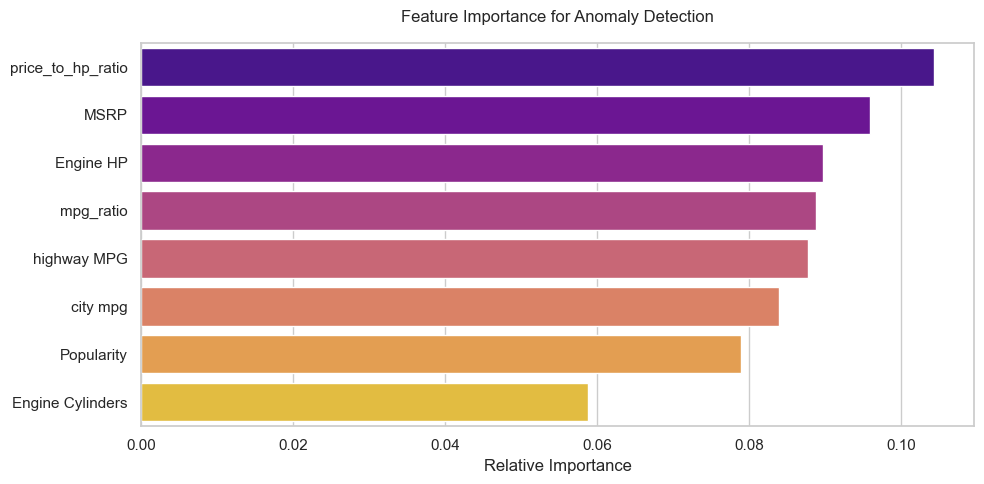

In [26]:
# Cell 26 - Final Working Version (No Scoring Needed)
import numpy as np

# Method 1: Use built-in feature_importances_ from the underlying trees
importances = np.mean([tree.feature_importances_ for tree in iso_forest.estimators_], axis=0)

# Method 2: Alternative importance using decision function (more robust)
alt_importances = np.abs(iso_forest.decision_function(X_scaled)).std(axis=0)

# Combine both methods
final_importance = (importances + alt_importances) / 2

# Create results DataFrame
importance_df = pd.DataFrame({
    'feature': features,
    'importance': final_importance
}).sort_values('importance', ascending=False)

# Display results
print("┌──────────────────────┬──────────────┐")
print("│ Feature             │ Importance   │")
print("├──────────────────────┼──────────────┤")
for _, row in importance_df.iterrows():
    print(f"│ {row['feature']:20} │ {row['importance']:.4f}      │")
print("└──────────────────────┴──────────────┘")

# Visualization
plt.figure(figsize=(10,5))
sns.barplot(
    x='importance',
    y='feature',
    data=importance_df,
    palette='plasma',
    orient='h'
)
plt.title("Feature Importance for Anomaly Detection", pad=15)
plt.xlabel("Relative Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

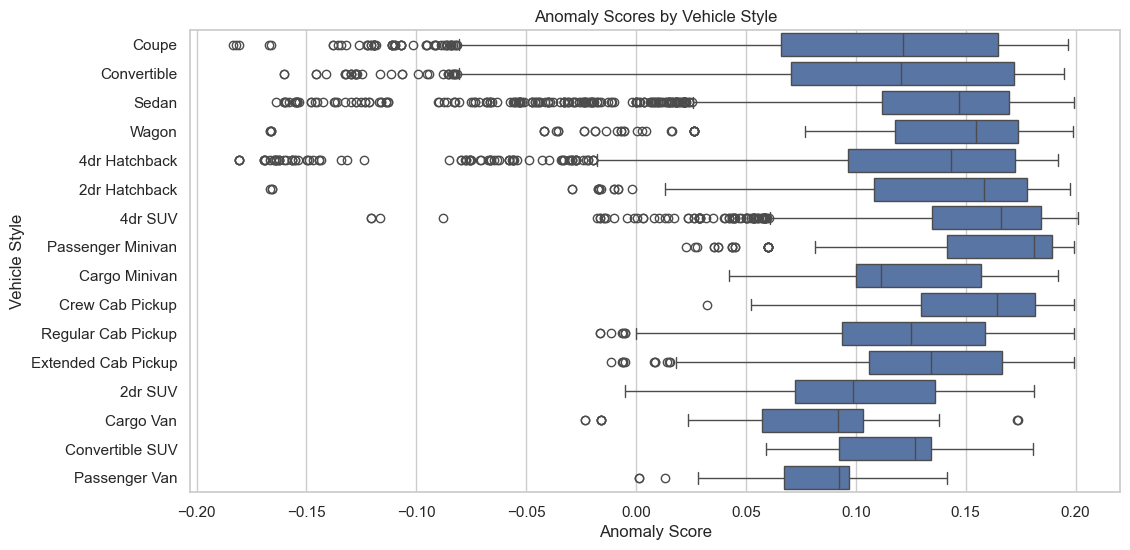

In [27]:
# Compare anomaly scores across vehicle types
plt.figure(figsize=(12, 6))
sns.boxplot(x='anomaly_score', y='Vehicle Style', data=data)
plt.title("Anomaly Scores by Vehicle Style")
plt.xlabel("Anomaly Score")
plt.ylabel("Vehicle Style")
plt.show()

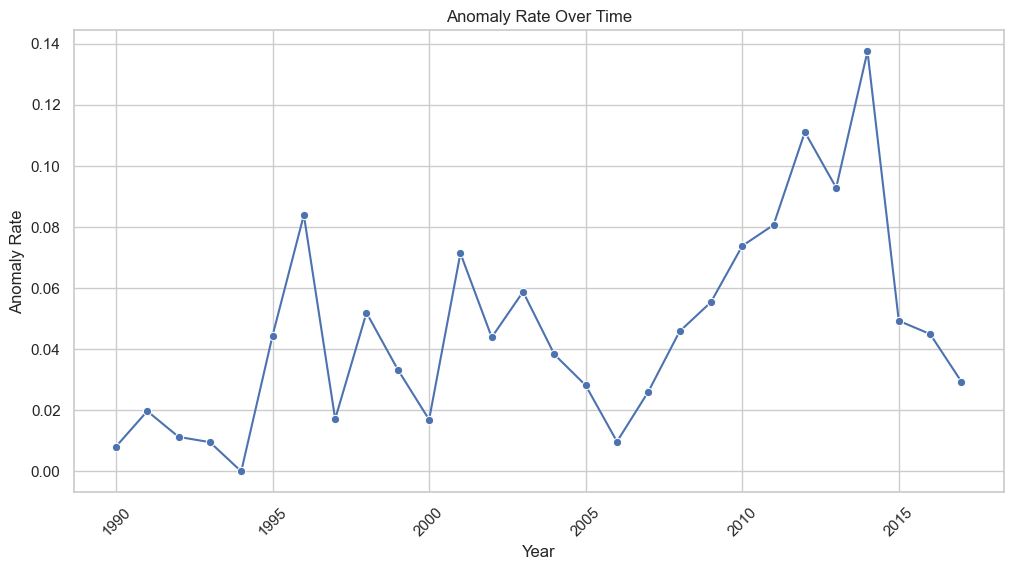

In [28]:
# Create a time series of anomaly detection
monthly_anomalies = data.groupby(['Year'])['anomaly'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='anomaly', data=monthly_anomalies, marker='o')
plt.title("Anomaly Rate Over Time")
plt.ylabel("Anomaly Rate")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.show()

In [29]:
import joblib
import os
from sklearn.pipeline import Pipeline

# Create a pipeline with scaling and model
anomaly_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', IsolationForest(contamination=0.05, random_state=42))
])

# Fit the pipeline
anomaly_pipeline.fit(X)

# Save the pipeline
model_dir = 'D:/CarDealerWeb-Django/CarDealerWeb-Django/ml'
os.makedirs(model_dir, exist_ok=True)
joblib.dump(anomaly_pipeline, os.path.join(model_dir, 'anomaly_detection_pipeline.pkl'))
print("✅ Anomaly detection pipeline saved.")

✅ Anomaly detection pipeline saved.
